# AdaBoost

In [10]:
# importing relevant packages and functions
%run /Users/thomasadler/Desktop/futuristic-platipus/notebooks/ta_00_packages_functions.py

In [4]:
# defining working directory
data_filepath = '/Users/thomasadler/Desktop/futuristic-platipus/data/'
model_filepath = '/Users/thomasadler/Desktop/futuristic-platipus/models/'
dictionary_filepath='/Users/thomasadler/Desktop/futuristic-platipus/data_dictionary/'
images_filepath = '/Users/thomasadler/Desktop/futuristic-platipus/images/'

# Preparing data

In [5]:
#clean dataset
modelling_df=pd.read_csv(data_filepath + 'master_modelling_df.csv', index_col=0)

#check
modelling_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107184 entries, 0 to 107183
Data columns (total 33 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   lat_deg                   107184 non-null  float64
 1   lon_deg                   107184 non-null  float64
 2   is_functioning            107184 non-null  int64  
 3   distance_to_primary       107184 non-null  float64
 4   distance_to_secondary     107184 non-null  float64
 5   distance_to_tertiary      107184 non-null  float64
 6   distance_to_city          107184 non-null  float64
 7   distance_to_town          107184 non-null  float64
 8   usage_cap                 107184 non-null  float64
 9   staleness_score           107184 non-null  float64
 10  is_complex_tech           107184 non-null  int64  
 11  is_installed_after_2006   107184 non-null  int64  
 12  is_public_management      107184 non-null  int64  
 13  crucialness               107184 non-null  f

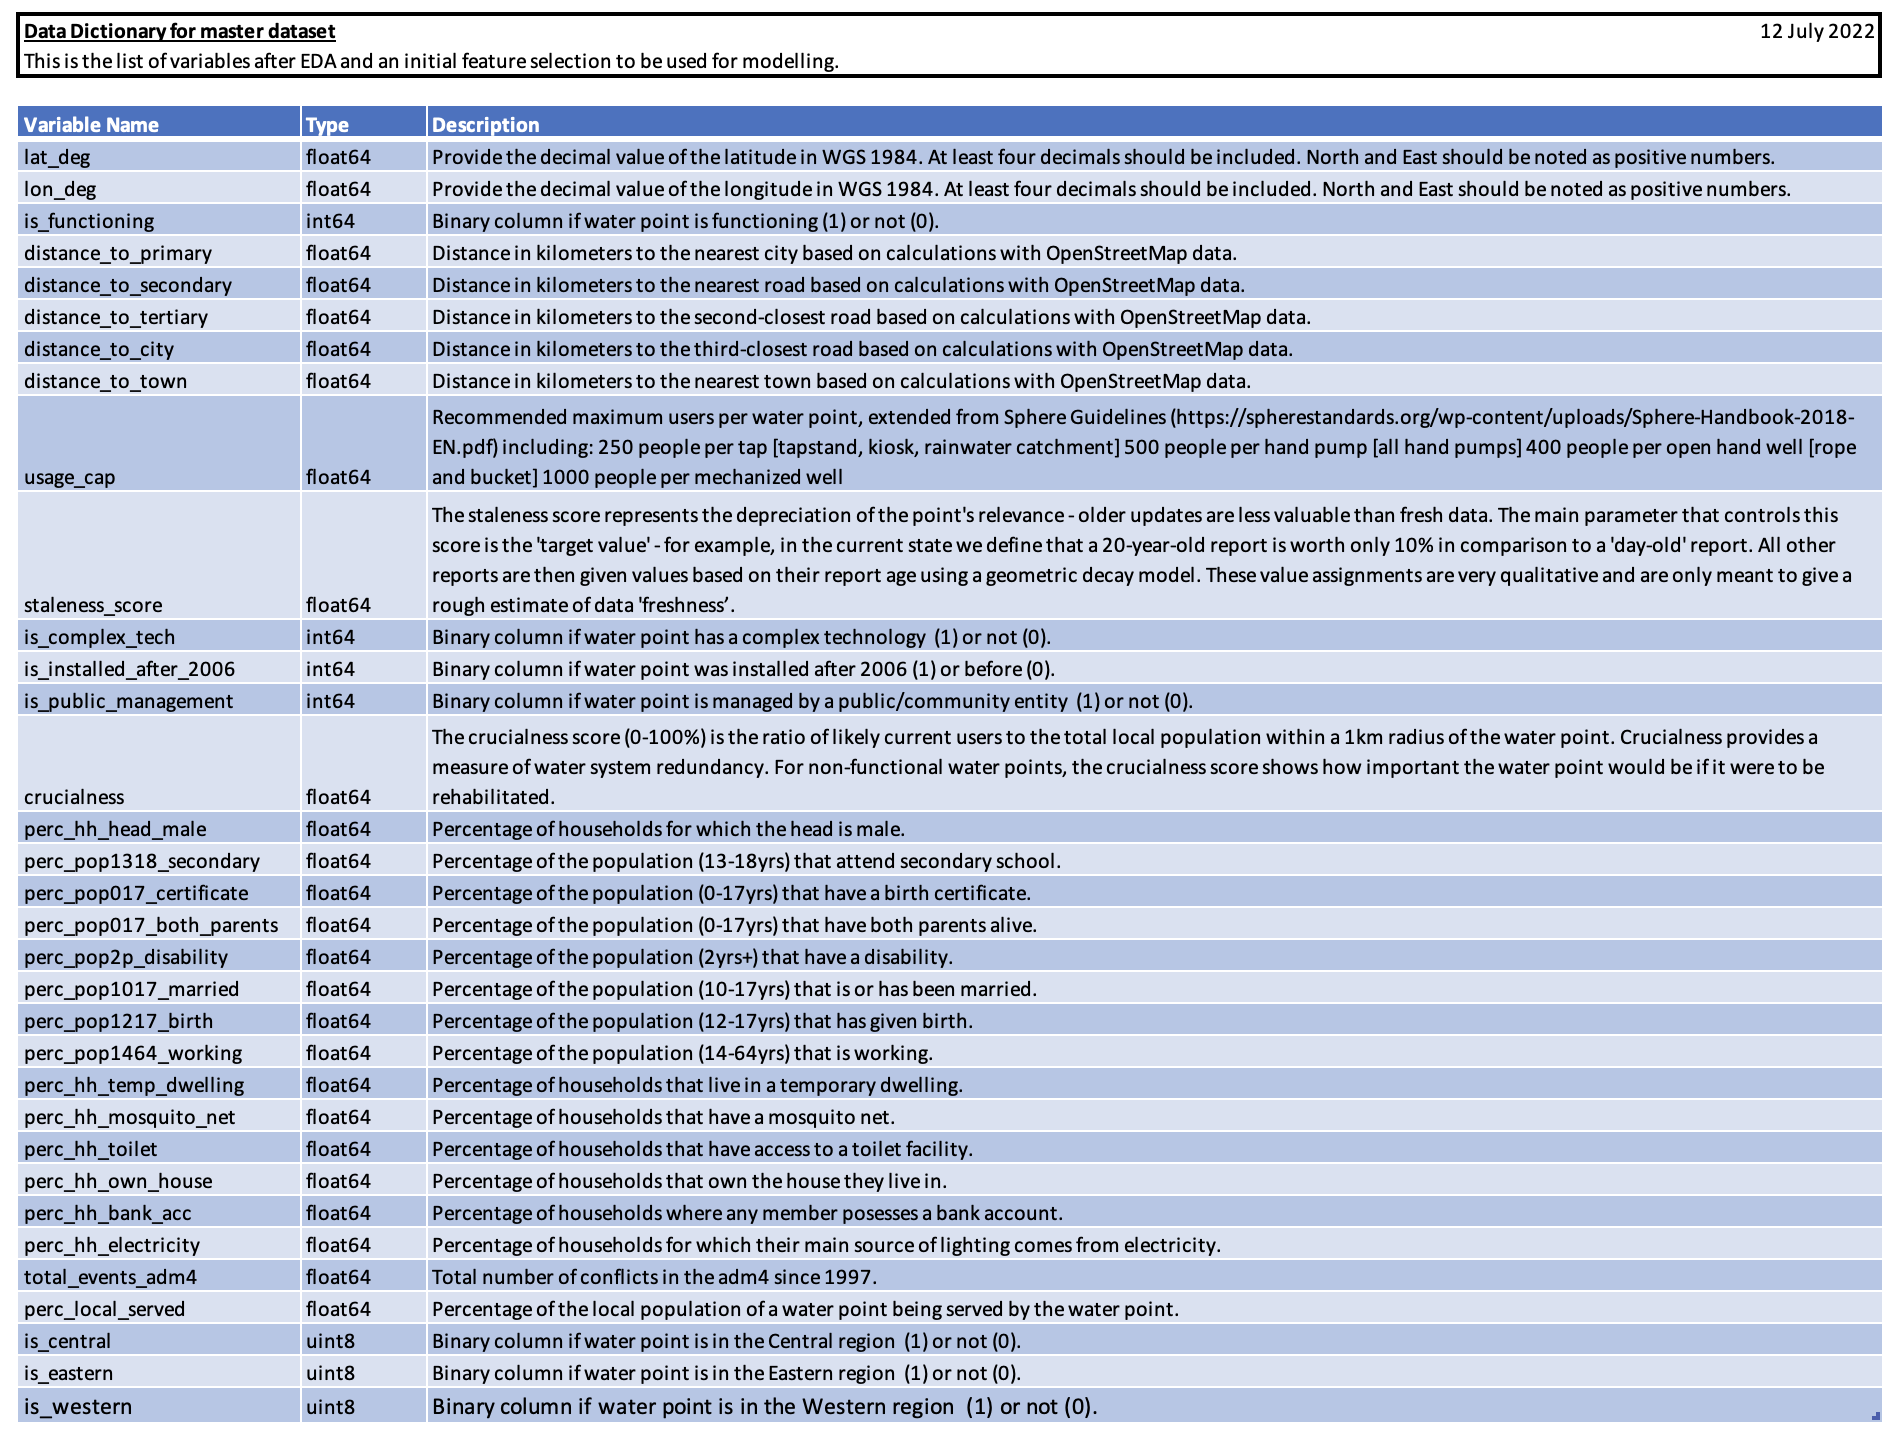

In [6]:
#data dictionary
Image(dictionary_filepath+"5-Modelling-Data-Dictionary.png")

In [7]:
#set random seed for consistent results
rand_seed=1

In [8]:
# assigning X (independent) and y (dependent) variables
X =modelling_df.loc[:, modelling_df.columns != 'is_functioning']
y = modelling_df['is_functioning']

#check
print(X.shape)
print(y.shape)

(107184, 32)
(107184,)


Our independent variable (X) should have the same number of rows (107,184) than our dependent variable (y). y should only have one column as it is the outcome variable.

In [9]:
#split train test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_seed)

In [12]:
# #resampling dataset
sm = SMOTE(random_state=rand_seed)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

#compre resampled dataset
print(f"Test set has {round(y_test.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_test.value_counts(normalize=True)[1]*100,1)}% functioning")
print(f"Original train set has {round(y_train.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_train.value_counts(normalize=True)[1]*100,1)}% functioning")
print(f"Resampled train set has {round(y_train_res.value_counts(normalize=True)[0]*100,1)}% non-functioning water points and {round(y_train_res.value_counts(normalize=True)[1]*100,1)}% functioning")

Test set has 19.7% non-functioning water points and 80.3% functioning
Original train set has 19.5% non-functioning water points and 80.5% functioning
Resampled train set has 50.0% non-functioning water points and 50.0% functioning


We over-sample the minority class, non-functioning water points, to get an equal distribution of our outcome variable. Note this should be done on the train set and not the test set as we should not tinker with the latter.

Note that we do not scale our data as random forest is not a distance-based ML model.

# Running baseline model

In [13]:
#time process
start=time.time()

#instantiate and fit
AB_base = AdaBoostClassifier(random_state=rand_seed).fit(X_train_res, y_train_res)

end=time.time()

time_fit_base=end-start

print(f"Time to fit the model on the training set is {round(time_fit_base,3)} seconds")

Time to fit the model on the training set is 16.167 seconds


We can already see that random forests are potentially very expensive. They are essentially multiple decision tress, which are already expensive by themselves.

ROC AUC: 0.7734391815190851
PR AUC: 0.7786255827186446
              precision    recall  f1-score   support

           0       0.68      0.75      0.71     68984
           1       0.72      0.65      0.68     68984

    accuracy                           0.70    137968
   macro avg       0.70      0.70      0.70    137968
weighted avg       0.70      0.70      0.70    137968



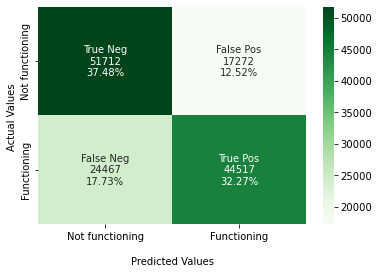

In [14]:
# get classification report for train 
fpr_train_base, tpr_train_base, roc_auc_train_base, precision_train_base_plot, recall_train_base_plot, pr_auc_train_base, time_predict_train_base = print_report(AB_base, X_train_res, y_train_res)

#storing accuracy scores
accuracy_train_base, precision_train_base, recall_train_base, f1_train_base = get_scores(AB_base, X_train_res, y_train_res)


As expected, our training set has close to perfect accuracy metrics. Random forests are composed of muktiple decision trees, which continue to make decision rules to be able to put all (or close to all) observations in the right classification bucket. For example, we only end up with 80 water points misclassified, representing less than 0.1% of the training dataset.

ROC AUC: 0.707622821456534
PR AUC: 0.9045064817764714
              precision    recall  f1-score   support

           0       0.31      0.65      0.42      4221
           1       0.88      0.64      0.74     17216

    accuracy                           0.65     21437
   macro avg       0.59      0.65      0.58     21437
weighted avg       0.77      0.65      0.68     21437



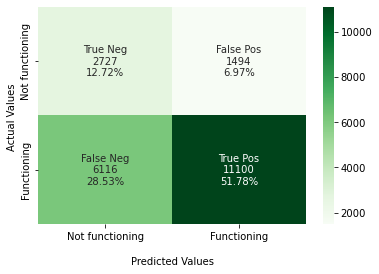

Time to predict the outcome variable for the test set is 0.155 seconds


In [15]:
# get classification report and confusion matrix for test
fpr_test_base, tpr_test_base, roc_auc_test_base, precision_test_base_plot, recall_test_base_plot, pr_auc_test_base, time_predict_test_base = print_report(AB_base, X_test, y_test)

print(f"Time to predict the outcome variable for the test set is {round(time_predict_test_base,3)} seconds")

#storing accuracy scores
accuracy_test_base, precision_test_base, recall_test_base, f1_test_base = get_scores(AB_base, X_test, y_test)

Our test set has an accuracy score of 82%. This is a very good score for a first run, baseline model. The precision and recall scores for non-functioning water points is quite low though while those for functioning points is close to 90%.

# Narrowing down parameters

We have seen in the decision tree model, that the choice of criterion (gini-purity or entropy-information gain) does not yield very different results. As a result, for this exploratory analysis we will not differentiate between the two.

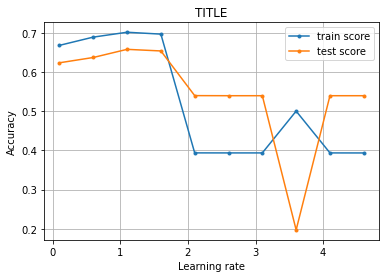

In [19]:
# look at the accuracy of the test score depending on the min sample leaf

# set range of sample leaf
learning_rate_range = np.arange(0.1, 5, 0.5)

#empty dataframe to store accuracy scores
accuracy_scores = pd.DataFrame()

for lr in learning_rate_range:

    #instantiate and fit
    AB = AdaBoostClassifier(learning_rate=lr, random_state=rand_seed).fit(
        X_train_res, y_train_res)

    # store accuracy scores
    train_score = AB.score(X_train_res, y_train_res)
    test_score = AB.score(X_test, y_test)

    # append to list
    accuracy_scores = accuracy_scores.append(
        {'Learning rate': lr, 'Train_score': train_score, 'Test_score': test_score}, ignore_index=True)

# visualise relationship between min sample leaf and accuracy
plt.figure()

plt.plot(accuracy_scores['Learning rate'],
         accuracy_scores['Train_score'], label='train score', marker='.')
plt.plot(accuracy_scores['Learning rate'],
         accuracy_scores['Test_score'], label='test score', marker='.')

plt.xlabel('Learning rate')
plt.ylabel("Accuracy")

plt.title("Ideal learning rate is below 1.5")
plt.legend(loc='best')
plt.grid()

plt.show()

As the minimum sample per leaf increases, the model accuracy decreases. This has the same shape and trend than single decision trees. Higher minimum samples per leaf might, however, prevent overfitting as it is more general and does not perfectly match the training set.

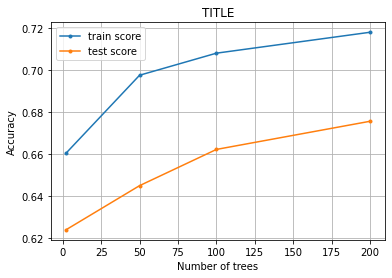

In [24]:
# look at the accuracy of the test score depending on the number of trees

# set range of depth max
n_estimators_range = [2, 50, 100, 200]

#empty dataframe to store results
accuracy_scores = pd.DataFrame()

#for gini
for n_est in n_estimators_range:

    #instantiate and fit
    AB = AdaBoostClassifier(n_estimators=n_est, random_state=rand_seed).fit(
        X_train_res, y_train_res)

    # store accuracy scores
    train_score = AB.score(X_train_res, y_train_res)
    test_score = AB.score(X_test, y_test)

    # append to list
    accuracy_scores = accuracy_scores.append(
        {'Number trees': n_est, 'Train_score': train_score, 'Test_score': test_score}, ignore_index=True)

# visualise relationship between number of trees and accuracy scores
plt.figure()

plt.plot(accuracy_scores['Number trees'],
         accuracy_scores['Train_score'], label='train score', marker='.')
plt.plot(accuracy_scores['Number trees'],
         accuracy_scores['Test_score'], label='test score', marker='.')

plt.xlabel('Number of trees')
plt.ylabel("Accuracy")

plt.title("TITLE")
plt.legend(loc='best')
plt.grid()

plt.show()

After the maximum depth passes the 32 mark, the model starts overfitting. As the max depth increases after 32, it seems the model does not need that big of a depth. This might make sense as we only have 32 features and the model is making one decision rule for each feature.

# Finding optimal hyperparameters

We run a randomised cross validation through a pipeline to find the optimal hyperparameters. We choose a randomised as opposed to a grid search because decision trees and random forest models are very expensive.

In [27]:
#setting hyparameter loop
learning_rate_range = np.arange(0.1, 1.5, 0.1)

# setting up which models/scalers we want to grid search
estimator = [('AB', AdaBoostClassifier(n_estimators=50, random_state=rand_seed))]

# defining distribution of parameters we want to compare
param_distrib = {'AB__learning_rate': learning_rate_range}

# run cross validation
pipeline_cross_val_random(estimator, param_distrib, X_train_res, y_train_res, X_test, y_test)

The model with the best CV score has the following parameters: {'AB__learning_rate': 1.3000000000000003}.
The best model has an accuracy score of 0.6537761813686617 on the test set


The best model has a max depth of 39 (vs 32 for the previous individual decision tree model) and minimum samples per leaf of 35, much larger than the choice of 9 from our previous decision tree (vs 9). It also chose the 'entropy' criterion, just like the individual decision tree.

# Running optimised model

In [29]:
#time process
start=time.time()

#instantiate and fit
AB_opt = AdaBoostClassifier(learning_rate=1.3, random_state=rand_seed).fit(X_train_res, y_train_res)

end=time.time()

time_fit_opt=end-start

print(f"Time to fit the model on the training set is {round(time_fit_opt, 3)} seconds")

Time to fit the model on the training set is 15.792 seconds


The time to fit the model is similar to the baseline model. We set the bootstrap and oob_score parameters to True so we can extract the importance of individual features later on.

ROC AUC: 0.7771923581738299
PR AUC: 0.7817139099769663
              precision    recall  f1-score   support

           0       0.69      0.73      0.71     68984
           1       0.71      0.66      0.69     68984

    accuracy                           0.70    137968
   macro avg       0.70      0.70      0.70    137968
weighted avg       0.70      0.70      0.70    137968



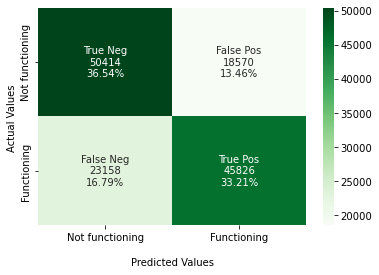

In [30]:
# get classification report for train
fpr_train_opt, tpr_train_opt, roc_auc_train_opt, precision_train_opt_plot, recall_train_opt_plot, pr_auc_train_opt, time_predict_train_opt = print_report(AB_opt, X_train_res, y_train_res)

#storing accuracy scores
accuracy_train_opt, precision_train_opt, recall_train_opt, f1_train_opt = get_scores(AB_opt, X_train_res, y_train_res)

The various accuracy metrics for the training set have all decreased (down to around 92%) compared to the baseline model (all at 100%). This is a good sign because the baseline model was hugely overfitting the training set while the optimised model i hopefully not.

ROC AUC: 0.7112377322759543
PR AUC: 0.9056770237972234
              precision    recall  f1-score   support

           0       0.31      0.63      0.42      4221
           1       0.88      0.66      0.75     17216

    accuracy                           0.65     21437
   macro avg       0.59      0.64      0.58     21437
weighted avg       0.77      0.65      0.69     21437



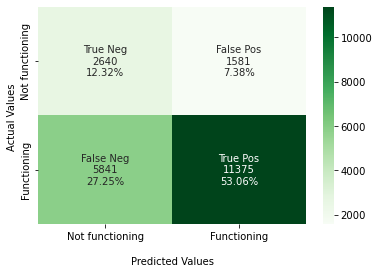

Time to predict the outcome variable for the test set is 0.162 seconds


In [31]:
# get classification report for test
fpr_test_opt, tpr_test_opt, roc_auc_test_opt, precision_test_opt_plot, recall_test_opt_plot, pr_auc_test_opt, time_predict_test_opt = print_report(AB_opt, X_test, y_test)

print(f"Time to predict the outcome variable for the test set is {round(time_predict_test_opt,3)} seconds")

#storing accuracy scores
accuracy_test_opt, precision_test_opt, recall_test_opt, f1_test_opt = get_scores(AB_opt, X_test, y_test)

The accuracy score is slightly lower for our optimised model. It has worsened its precision score for non-functioning points while improving its recall score. This means it is getting better at identifying more non-functioning water points, at the expense of labelling more functioning water points as functioning.

# Comparing results

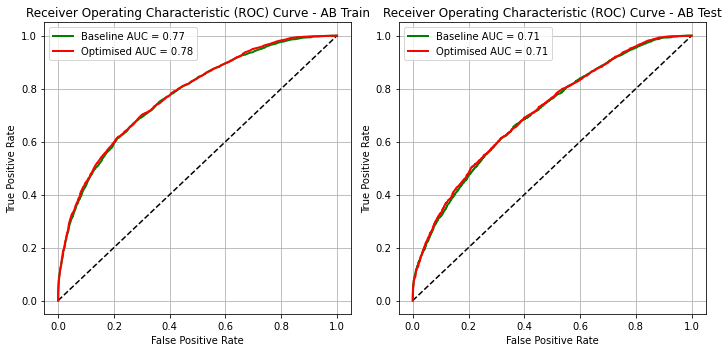

In [32]:
#compare ROCs on train and test

plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve - AB Train')
plt.plot(fpr_train_base, tpr_train_base, color='green', lw=2,
    label='Baseline AUC = %0.2f' % roc_auc_train_base)
plt.plot(fpr_train_opt, tpr_train_opt, color='red', lw=2,
    label='Optimised AUC = %0.2f' % roc_auc_train_opt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

plt.subplot(1,2,2)
plt.plot([0,1], [0,1], color='black', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve - AB Test')
plt.plot(fpr_test_base, tpr_test_base, color='green', lw=2,
    label='Baseline AUC = %0.2f' % roc_auc_test_base)
plt.plot(fpr_test_opt, tpr_test_opt, color='red', lw=2,
    label='Optimised AUC = %0.2f' % roc_auc_test_opt)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

plt.show()


The optimised model has a worse AUC on the train set because it is being prevented from overfitting. We are more concerned with the test set AUC. Here the optimised model performs the same as the baseline model. The baseline has a very slight edge on the precision and recall scores, so we go with the baseline model as the best one.

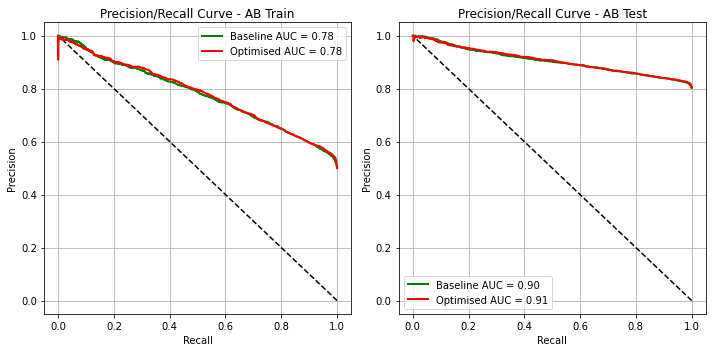

In [33]:
#compare Precision/Recall Curve on train and test

plt.subplots(1,2, figsize=(10,5))
plt.subplot(1,2,1)
plt.plot([1,0], [0,1], color='black', linestyle='--')
plt.title('Precision/Recall Curve - AB Train')
plt.plot(recall_train_base_plot, precision_train_base_plot, color='green', lw=2,
    label='Baseline AUC = %0.2f' % pr_auc_train_base)
plt.plot(recall_train_opt_plot, precision_train_opt_plot, color='red', lw=2,
    label='Optimised AUC = %0.2f' % pr_auc_train_opt)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

plt.subplot(1,2,2)
plt.plot([1,0], [0,1], color='black', linestyle='--')
plt.title('Precision/Recall Curve - AB Test')
plt.plot(recall_test_base_plot, precision_test_base_plot, color='green', lw=2,
    label='Baseline AUC = %0.2f' % pr_auc_test_base)
plt.plot(recall_test_opt_plot, precision_test_opt_plot, color='red', lw=2,
    label='Optimised AUC = %0.2f' % pr_auc_test_opt)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="best")
plt.tight_layout()
plt.grid()

plt.show()


# Visualising feature importance

In [34]:
#what are the most important coefficients for the best model?
coefficients=pd.DataFrame(data=AB_opt.feature_importances_, index=X.columns).reset_index()

#rename columns
coefficients.set_axis(['feature', 'coefficient'], axis=1, inplace=True)

#sorting values
coefficients=coefficients.sort_values('coefficient', ascending=False)

#check
coefficients

,feature,coefficient
8,staleness_score,0.34
27,total_events_adm4,0.16
12,crucialness,0.10
7,usage_cap,0.08
0,lat_deg,0.06
11,is_public_management,0.04
24,perc_hh_own_house,0.04
30,is_eastern,0.02
28,perc_local_served,0.02
21,perc_hh_temp_dwelling,0.02


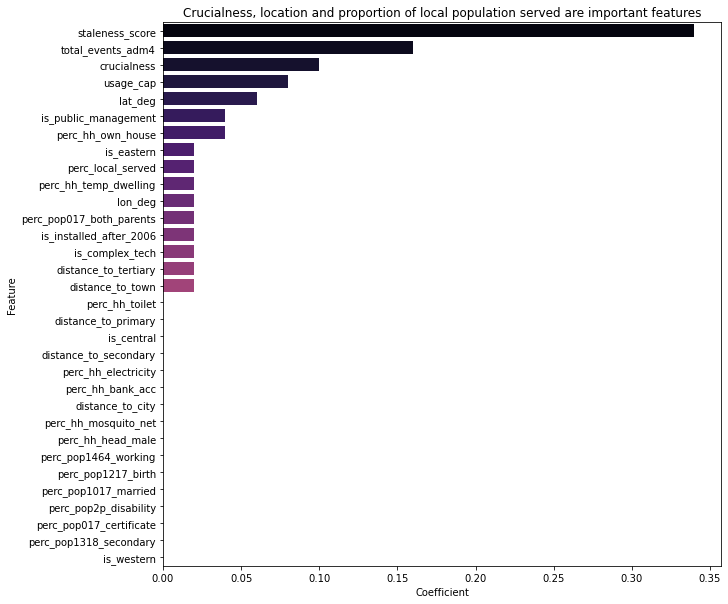

In [35]:
# visualise coefficient importance
plt.figure(figsize=(10,10))

sns.barplot(data=coefficients, x='coefficient', y='feature', palette='magma', orient='horizontal')

plt.xlabel('Coefficient')
plt.ylabel('Feature')

plt.xticks()
plt.yticks()
plt.legend([],[], frameon=False)
plt.title('TITLE')

plt.show()

We see a water points' importance to their crucial to their communities and the proportion of the community being served by the community are two very important features for the decision tree's splitting. The latitude and longitude of the points are also very important, which is probably why the region dummy columns are not given much importance. We see, notably, that the number of conflicts/violent events are not very important for our model.

# Exporting

In [42]:
#export model results-this is very large and cannot be pushed to our git repo
joblib.dump(AB_opt, model_filepath+'adaboost_model.sav')

['/Users/thomasadler/Desktop/futuristic-platipus/models/random_forest_model.sav']

In [36]:
#export best model in dataframe
d = {'Model':['AdaBoost'], 'Parameters':['Learning rate=1.3, Number of trees=50'], 'Accuracy Train': [accuracy_train_opt],\
    'Precision Train': [precision_train_opt], 'Recall Train': [recall_train_opt], 'F1 Train': [f1_train_opt], 'FPR Train Plot': [fpr_train_opt],\
        'TPR Train Plot':[tpr_train_opt], 'ROC AUC Train':[roc_auc_train_opt], 'Precision Train Plot': [precision_train_opt_plot],\
            'Recall Train Plot':[recall_train_opt_plot], 'PR AUC Train':[pr_auc_train_opt], 'Accuracy Test': accuracy_test_opt,\
                'Precision Test': [precision_test_opt], 'Recall Test': [recall_test_opt], 'F1 Test': [f1_test_opt], 'FPR Test Plot': [fpr_test_opt],\
                    'TPR Test Plot':[tpr_test_opt], 'ROC AUC Test':[roc_auc_test_opt], 'Precision Test Plot': [precision_test_opt_plot],\
                        'Recall Test Plot':[recall_test_opt_plot], 'PR AUC Test':[pr_auc_test_opt], 'Time Fit': time_fit_opt, 'Time Predict': time_predict_test_opt}

#to dataframe
best_model_result_df=pd.DataFrame(data=d)

#check
best_model_result_df

,Model,Parameters,Accuracy Train,Precision Train,Recall Train,F1 Train,FPR Train Plot,TPR Train Plot,ROC AUC Train,Precision Train Plot,...,Recall Test,F1 Test,FPR Test Plot,TPR Test Plot,ROC AUC Test,Precision Test Plot,Recall Test Plot,PR AUC Test,Time Fit,Time Predict
0,AdaBoost,"Learning rate=1.3, Number of trees=50",0.697553,0.698431,0.697553,0.697218,"[0.0, 0.0, 0.0, 0.0, 1.4496115041168967e-05, 1...","[0.0, 1.4496115041168967e-05, 5.79844601646758...",0.777192,"[0.500264694151347, 0.5002610700973211, 0.5002...",...,0.653776,0.687393,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.808550185873606e-05, 0.000290427509293...",0.711238,"[0.8031723816188476, 0.8031631986563404, 0.803...","[1.0, 0.9999419144981413, 0.9999419144981413, ...",0.905677,15.791898,0.16178


In [37]:
#export new dataset
best_model_result_df.to_csv(model_filepath + 'adaboost_model.csv')